In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


In [2]:
# Step 1: Load the Dataset
file_path = 'processed_data_with_fingerprints.csv'  # Modified CSV file
data = pd.read_csv(file_path)

In [3]:
# Step 2: Prepare Features and Labels
#feature_columns = ['Temperature (K)','MolecularWeight', 'NumAtoms', 'NumBonds', 'LogP', 'NumRotatableBonds', 'TPSA']  # Modify based on your features
feature_columns = [str(i) for i in range(1024)] + ['Inverse temperature (1/K)']
label_column = 'log(Viscosity)'  # What we learn

# Normalize the features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(data[feature_columns])

# Convert to PyTorch tensor
features = torch.tensor(normalized_features, dtype=torch.float32)
labels = torch.tensor(data[label_column].values, dtype=torch.float32).view(-1, 1)  # Ensure labels are 2D for regression/classification
print(features.shape)

torch.Size([3582, 1025])


In [4]:
# Step 3: Create a Custom Dataset
class MolecularDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

dataset = MolecularDataset(features, labels)

In [5]:
# Step 4: Split Dataset into Training and Testing
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
# Step 5: Define the Lightning Module
class FullyConnectedNN(pl.LightningModule):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1025, 2024),  # Input layer (6 features) to first hidden layer
            nn.ReLU(),
            nn.Linear(2024, 1024),  # First hidden layer to second hidden layer
            nn.ReLU(),
            nn.Linear(1024, 1024),  # Second hidden layer to third hidden layer
            nn.ReLU(),
            nn.Linear(1024, 512),  # Third hidden layer to fourth hidden layer
            nn.ReLU(),
            nn.Linear(512, 512),  # Third hidden layer to fourth hidden layer
            nn.ReLU(),
            nn.Linear(512, 256),  # Third hidden layer to fourth hidden layer
            nn.ReLU(),
            nn.Linear(256, 128),  # Third hidden layer to fourth hidden layer
            nn.ReLU(),
            nn.Linear(128, 64),  # Third hidden layer to fourth hidden layer
            nn.ReLU(),
            nn.Linear(64, 64),  # Third hidden layer to fourth hidden layer
            nn.ReLU(),
            nn.Linear(64, 32),  # Third hidden layer to fourth hidden layer
            nn.ReLU(),
            nn.Linear(32, 1)    # Fourth hidden layer to output (1 regression target)
        )
        self.loss_fn = nn.MSELoss()  # Mean Squared Error for regression
        #self.loss_fn = RelativeMeanSquaredDeviationLoss()
        self.initialize_weights() 
        self.train_losses = []  # Store test losses
        self.val_losses = []  # Store validation losses
        self.test_losses = []  # Store test losses

    def initialize_weights(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                init.zeros_(layer.bias)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        predictions = self(inputs)
        loss = self.loss_fn(predictions, targets)
        self.log('batch_train_loss', loss, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        predictions = self(inputs)
        val_loss = self.loss_fn(predictions, targets)
        #self.val_losses.append(val_loss.item())
        self.log('val_loss', val_loss, prog_bar=False)

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        predictions = self(inputs)
        test_loss = self.loss_fn(predictions, targets)
        self.test_losses.append(test_loss.item())
        self.log('test_loss', test_loss, prog_bar=True)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)
    """
    def on_train_epoch_end(self):
        Custom logging after each epoch.
        print(f"\n[Epoch {self.current_epoch + 1}] Train Loss: {self.trainer.logged_metrics.get('train_loss'):.4f}")
    """
    
    def on_train_epoch_end(self):
        """Calculate and log the average training loss per epoch."""
        epoch_train_loss = self.trainer.logged_metrics.get("batch_train_loss")
        if epoch_train_loss is not None:
            self.train_losses.append(epoch_train_loss.item())
            print(f"\n[Epoch {self.current_epoch + 1}] Avg Train Loss: {epoch_train_loss:.4f}")

    def on_validation_epoch_end(self):
        """Custom logging after validation."""
        val_loss = self.trainer.logged_metrics.get('val_loss')
        if val_loss is not None:
            self.val_losses.append(val_loss.item())
            print(f"[Epoch {self.current_epoch + 1}] Validation Loss: {val_loss:.4f}" if val_loss else "[No validation step performed]")

    def on_fit_end(self):
        """Log model parameters after training."""
        print("\n[Training Complete]")
        print("Model Parameters:")
        for name, param in self.named_parameters():
            print(f"{name}: {param.data}")
            
    def on_test_epoch_end(self):
        # Calculate the average test loss over all batches
        avg_test_loss = sum(self.test_losses) / len(self.test_losses)
        self.avg_test_loss = avg_test_loss  # Save to an attribute for later use
        print(f"Average Test Loss: {avg_test_loss:.4f}")
        self.log('avg_test_loss', avg_test_loss)  # Optional: Log for Lightning
        self.test_losses = []  # Reset for next test run if needed

# Step 6: Initialize the Model
model = FullyConnectedNN()
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    verbose=True,
    mode='min'
)

# Step 7: Initialize the Trainer and Train the Model
trainer = pl.Trainer(max_epochs=100, 
                     log_every_n_steps=10, 
                     accelerator='auto',
                     enable_progress_bar=False,
                     callbacks=[early_stopping],
                     check_val_every_n_epoch=1,
                    )  # Adjust accelerator for GPUs if available

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Step 8: Test the Model
trainer.test(dataloaders=test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ynan/miniconda3/envs/rdkit_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 6.2 M  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.664    Total estimated model para

[Epoch 1] Validation Loss: 0.2963


Metric val_loss improved. New best score: 0.109


[Epoch 1] Validation Loss: 0.1086

[Epoch 1] Avg Train Loss: 0.0857


Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.073


[Epoch 2] Validation Loss: 0.0733

[Epoch 2] Avg Train Loss: 0.0336


Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.067


[Epoch 3] Validation Loss: 0.0670

[Epoch 3] Avg Train Loss: 0.0309


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.065


[Epoch 4] Validation Loss: 0.0647

[Epoch 4] Avg Train Loss: 0.0177


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.059


[Epoch 5] Validation Loss: 0.0595

[Epoch 5] Avg Train Loss: 0.0143


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.058


[Epoch 6] Validation Loss: 0.0580

[Epoch 6] Avg Train Loss: 0.0137


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.058


[Epoch 7] Validation Loss: 0.0580

[Epoch 7] Avg Train Loss: 0.0212


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.056


[Epoch 8] Validation Loss: 0.0564

[Epoch 8] Avg Train Loss: 0.0296


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.056


[Epoch 9] Validation Loss: 0.0559

[Epoch 9] Avg Train Loss: 0.0083


Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.054


[Epoch 10] Validation Loss: 0.0542

[Epoch 10] Avg Train Loss: 0.0205
[Epoch 11] Validation Loss: 0.0566

[Epoch 11] Avg Train Loss: 0.0274


Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.051


[Epoch 12] Validation Loss: 0.0513

[Epoch 12] Avg Train Loss: 0.0056
[Epoch 13] Validation Loss: 0.0520

[Epoch 13] Avg Train Loss: 0.0104
[Epoch 14] Validation Loss: 0.0532

[Epoch 14] Avg Train Loss: 0.0467


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.051


[Epoch 15] Validation Loss: 0.0510

[Epoch 15] Avg Train Loss: 0.0093


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.050


[Epoch 16] Validation Loss: 0.0501

[Epoch 16] Avg Train Loss: 0.0228
[Epoch 17] Validation Loss: 0.0564

[Epoch 17] Avg Train Loss: 0.0064
[Epoch 18] Validation Loss: 0.0525

[Epoch 18] Avg Train Loss: 0.0751


Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.049


[Epoch 19] Validation Loss: 0.0488

[Epoch 19] Avg Train Loss: 0.0170
[Epoch 20] Validation Loss: 0.0506

[Epoch 20] Avg Train Loss: 0.0273
[Epoch 21] Validation Loss: 0.0537

[Epoch 21] Avg Train Loss: 0.0324
[Epoch 22] Validation Loss: 0.0509

[Epoch 22] Avg Train Loss: 0.0500
[Epoch 23] Validation Loss: 0.0544

[Epoch 23] Avg Train Loss: 0.0261
[Epoch 24] Validation Loss: 0.0525

[Epoch 24] Avg Train Loss: 0.0299
[Epoch 25] Validation Loss: 0.0509

[Epoch 25] Avg Train Loss: 0.0089
[Epoch 26] Validation Loss: 0.0494

[Epoch 26] Avg Train Loss: 0.0858


Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.048


[Epoch 27] Validation Loss: 0.0484

[Epoch 27] Avg Train Loss: 0.0283
[Epoch 28] Validation Loss: 0.0498

[Epoch 28] Avg Train Loss: 0.0039
[Epoch 29] Validation Loss: 0.0577

[Epoch 29] Avg Train Loss: 0.0232
[Epoch 30] Validation Loss: 0.0515

[Epoch 30] Avg Train Loss: 0.0106
[Epoch 31] Validation Loss: 0.0543

[Epoch 31] Avg Train Loss: 0.0809
[Epoch 32] Validation Loss: 0.0532

[Epoch 32] Avg Train Loss: 0.0468
[Epoch 33] Validation Loss: 0.0515

[Epoch 33] Avg Train Loss: 0.0427
[Epoch 34] Validation Loss: 0.0504

[Epoch 34] Avg Train Loss: 0.0049
[Epoch 35] Validation Loss: 0.0516

[Epoch 35] Avg Train Loss: 0.0435
[Epoch 36] Validation Loss: 0.0504

[Epoch 36] Avg Train Loss: 0.0459
[Epoch 37] Validation Loss: 0.0504

[Epoch 37] Avg Train Loss: 0.0721
[Epoch 38] Validation Loss: 0.0495

[Epoch 38] Avg Train Loss: 0.0440
[Epoch 39] Validation Loss: 0.0516

[Epoch 39] Avg Train Loss: 0.0055
[Epoch 40] Validation Loss: 0.0515

[Epoch 40] Avg Train Loss: 0.0147
[Epoch 41] Validatio

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.048


[Epoch 49] Validation Loss: 0.0479

[Epoch 49] Avg Train Loss: 0.0054
[Epoch 50] Validation Loss: 0.0498

[Epoch 50] Avg Train Loss: 0.0046
[Epoch 51] Validation Loss: 0.0495

[Epoch 51] Avg Train Loss: 0.0305
[Epoch 52] Validation Loss: 0.0503

[Epoch 52] Avg Train Loss: 0.0213
[Epoch 53] Validation Loss: 0.0507

[Epoch 53] Avg Train Loss: 0.0632
[Epoch 54] Validation Loss: 0.0482

[Epoch 54] Avg Train Loss: 0.0106
[Epoch 55] Validation Loss: 0.0495

[Epoch 55] Avg Train Loss: 0.0410
[Epoch 56] Validation Loss: 0.0497

[Epoch 56] Avg Train Loss: 0.0046
[Epoch 57] Validation Loss: 0.0513

[Epoch 57] Avg Train Loss: 0.0487
[Epoch 58] Validation Loss: 0.0502

[Epoch 58] Avg Train Loss: 0.0110
[Epoch 59] Validation Loss: 0.0488

[Epoch 59] Avg Train Loss: 0.0380
[Epoch 60] Validation Loss: 0.0509

[Epoch 60] Avg Train Loss: 0.0170
[Epoch 61] Validation Loss: 0.0507

[Epoch 61] Avg Train Loss: 0.0232
[Epoch 62] Validation Loss: 0.0517

[Epoch 62] Avg Train Loss: 0.0121
[Epoch 63] Validatio

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.046


[Epoch 72] Validation Loss: 0.0462

[Epoch 72] Avg Train Loss: 0.0138
[Epoch 73] Validation Loss: 0.0477

[Epoch 73] Avg Train Loss: 0.0369
[Epoch 74] Validation Loss: 0.0497

[Epoch 74] Avg Train Loss: 0.0212
[Epoch 75] Validation Loss: 0.0484

[Epoch 75] Avg Train Loss: 0.0100
[Epoch 76] Validation Loss: 0.0475

[Epoch 76] Avg Train Loss: 0.0159
[Epoch 77] Validation Loss: 0.0506

[Epoch 77] Avg Train Loss: 0.0049
[Epoch 78] Validation Loss: 0.0496

[Epoch 78] Avg Train Loss: 0.0271
[Epoch 79] Validation Loss: 0.0512

[Epoch 79] Avg Train Loss: 0.0014
[Epoch 80] Validation Loss: 0.0511

[Epoch 80] Avg Train Loss: 0.0158
[Epoch 81] Validation Loss: 0.0478

[Epoch 81] Avg Train Loss: 0.0232
[Epoch 82] Validation Loss: 0.0475

[Epoch 82] Avg Train Loss: 0.0167
[Epoch 83] Validation Loss: 0.0505

[Epoch 83] Avg Train Loss: 0.0067
[Epoch 84] Validation Loss: 0.0504

[Epoch 84] Avg Train Loss: 0.0069
[Epoch 85] Validation Loss: 0.0519

[Epoch 85] Avg Train Loss: 0.0253
[Epoch 86] Validatio

`Trainer.fit` stopped: `max_epochs=100` reached.
/home/ynan/miniconda3/envs/rdkit_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/ynan/tmp/mygit/Viscosity/lightning_logs/version_48/checkpoints/epoch=99-step=7900.ckpt


[Epoch 100] Validation Loss: 0.0490

[Epoch 100] Avg Train Loss: 0.0006

[Training Complete]
Model Parameters:
model.0.weight: tensor([[-0.0693, -0.0241, -0.1052,  ...,  0.0012,  0.0574, -0.0647],
        [-0.0225, -0.0287,  0.0787,  ..., -0.0218, -0.0031, -0.0067],
        [ 0.0253, -0.0483,  0.0735,  ..., -0.0557, -0.0117,  0.3378],
        ...,
        [-0.0098,  0.0301, -0.0699,  ...,  0.1159,  0.0523, -0.4017],
        [-0.0716,  0.0667, -0.0673,  ...,  0.0672, -0.0472, -0.0171],
        [ 0.0230, -0.0187,  0.0157,  ...,  0.1125, -0.0165, -0.1438]])
model.0.bias: tensor([-0.0574, -0.0611, -0.0734,  ...,  0.0551,  0.0171,  0.0252])
model.2.weight: tensor([[-0.0414, -0.0337, -0.0261,  ..., -0.0560, -0.0021, -0.0413],
        [-0.0107,  0.0102,  0.0292,  ...,  0.0074, -0.0594,  0.0388],
        [-0.0488,  0.0082, -0.0579,  ...,  0.0359, -0.0409, -0.0356],
        ...,
        [-0.0445,  0.0051, -0.0054,  ..., -0.0351, -0.0322,  0.0062],
        [ 0.0171,  0.0154,  0.0391,  ..., -0.05

Loaded model weights from the checkpoint at /home/ynan/tmp/mygit/Viscosity/lightning_logs/version_48/checkpoints/epoch=99-step=7900.ckpt


Average Test Loss: 0.0547
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      avg_test_loss        0.054717641323804855
        test_loss           0.05464239791035652
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/ynan/miniconda3/envs/rdkit_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


[{'test_loss': 0.05464239791035652, 'avg_test_loss': 0.054717641323804855}]

101
100


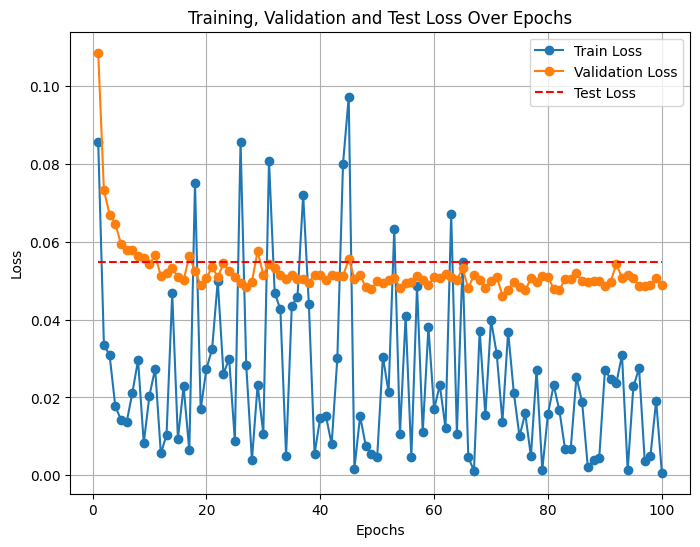

In [7]:
import matplotlib.pyplot as plt

# Step 1: Get the losses
val_losses = model.val_losses
train_losses = model.train_losses
test_loss = model.avg_test_loss 

val_losses_aligned = val_losses[1:] 
# Step 2: Plot the validation and test loss
epochs = range(1, len(val_losses))  # Create epoch numbers
print(len(val_losses))
#print(len(test_losses))
print(len(train_losses))


plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses_aligned, label='Validation Loss', marker='o')
plt.plot(epochs, [test_loss] * len(epochs), label='Test Loss', linestyle='--', color='red')  # Constant line for test loss
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation and Test Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


2507


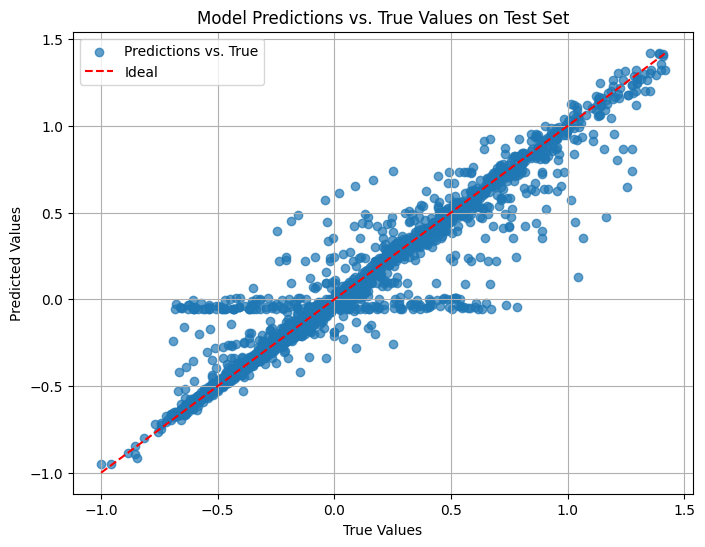

In [8]:
import matplotlib.pyplot as plt
import torch

# Step 1: Get Predictions and True Values
model.eval()  # Ensure the model is in evaluation mode
predictions = []
true_values = []

with torch.no_grad():  # Disable gradient computation for testing
    for batch in train_loader:
        inputs, targets = batch
        preds = model(inputs)  # Get model predictions
        predictions.extend(preds.cpu().numpy())
        true_values.extend(targets.cpu().numpy())

# Step 2: Convert to Arrays for Plotting
import numpy as np
predictions = np.array(predictions).flatten()  # Flatten in case it's multi-dimensional
true_values = np.array(true_values).flatten()

print(len(true_values))

# Step 3: Create a Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, predictions, alpha=0.7, label='Predictions vs. True')
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Model Predictions vs. True Values on Test Set')
plt.legend()
plt.grid()
plt.show()


In [9]:
# Step 1: Calculate the absolute difference
differences = np.abs(predictions - true_values)

# Step 2: Identify indices where difference > 0.5
large_diff_indices = np.where(differences > 0.7)[0]  # Get indices of large differences

# Step 3: Print out details for these indices
for idx in large_diff_indices:
    temp = data.iloc[idx]['Temperature (K)']  # Replace 'temperature' with the correct column name
    model = data.iloc[idx]['CANON_SMILES']       # Replace 'model' with the correct column name
    print(f"Index: {idx}, Temperature: {temp}, Model: {model}, True: {true_values[idx]}, Predicted: {predictions[idx]}, Difference: {differences[idx]:.2f}")


Index: 66, Temperature: 288.25, Model: C#N, True: 0.6711728572845459, Predicted: -0.05624091997742653, Difference: 0.73
Index: 648, Temperature: 313.15, Model: CC(C)CCCC(C)CCCC(C)CCCCC(C)CCCC(C)CCCC(C)C, True: 1.0453230142593384, Predicted: 0.1291719675064087, Difference: 0.92
Index: 780, Temperature: 293.15, Model: CC(C)OC=O, True: 0.7371926307678223, Predicted: -0.03003433346748352, Difference: 0.77
Index: 1540, Temperature: 311.0, Model: CCCCCCCCCCCCCC, True: 0.781036913394928, Predicted: -0.042831387370824814, Difference: 0.82
Index: 2228, Temperature: 313.1, Model: CCOC(=O)c1ccccc1C(=O)OCC, True: 1.0644580125808716, Predicted: 0.35498252511024475, Difference: 0.71
